In [82]:
"""Conversion of flow cytometry data into conditional output distributions
   and response function with quintiles.

Author: Swarnavo Sarkar
Email: swarnavo.sarkar@nist.gov

If you are using SEMIL and any of the pre and postprocessing code, please cite 
'Mutual Information Landscapes as a Performance Metric for Biochemical Reaction Networks'
"""


import glob #filenames and pathnames utility
import os   #operating sytem utility
import numpy as np
import pandas as pd
import pickle
import random as rand
import sys
import math

import matplotlib.pyplot as plt

In [97]:
# Directory where the cytometry dataframes are located
#data_directory = '/Users/sns9/Research/IMS_project/FeedbackExpDec18/WTA'

data_directory = '/Volumes/Shared_Data/GSF-IMS/E-Coli/pLMSF-lacI/2020-02-25_IPTG-Cytom-12-plasmids/plate_1'

output_directory = '/Volumes/Shared_Data/GSF-IMS/E-Coli/pLMSF-lacI/2020-02-25_IPTG-Cytom-12-plasmids'

os.chdir(data_directory)

In [98]:
# Subsamples (with replacements) for obtaining output distributions
# will be used for correcting for finite-sampling
data_fractions = [1,2,5,10]
n_samples = list(range(1,6))

# Number of bins to bin cytometry data
n_bins = 200

# Quintiles for error bounds to the response curve
q_up, q_low = 95.0, 5.0

In [99]:
# Labels for plate and experimental replicate
plate_label = ['C']
rep_label = 'pVER-IPTG-048'
tag = 'pVER-IPTG-048'
filter_string = 'pVER-IPTG-048-'
conc_separator = '-'
plate_separator = '_'
data_fractions = [1,2,5,10]
n_subsamples = 5

In [100]:
coli_files = glob.glob('*.frame_pkl')

filenames = [file.rsplit('.',1)[0] for file in coli_files]

coli_frame = [ pickle.load(open(file, 'rb')) for file in coli_files ]

for file in filenames:
    if 'summary' in file:
        summary_idx = filenames.index(file)

del filenames[summary_idx]
del coli_frame[summary_idx]

#filenames = [file.rsplit('.',1)[0] for file in coli_files]

#coli_frame = [ pickle.load(open(file, 'rb')) for file in coli_files ]

singlet_data = [frame.loc[frame['is_singlet']] for frame in coli_frame]

In [101]:
data_covered = []

location_string = {}
wt_string = {}

means = {}
quints = {}
percents = {}

In [102]:
index_set = None
data_size = 0

conclist = []
datas = {}

In [103]:
fl_channel = 'BL1-A-MEF'
glob_min = 1000000
glob_max = 0

for i, singlet in zip(range(len(singlet_data)), singlet_data):
    index_set = None
    for j in range(1):
        label, plate_no = filenames[i].split(plate_separator)
        this_plate = plate_no[0]

        if (plate_label[0] in plate_no) and rep_label in label: # or plate_label[1] in plate_no
            print(label)

            conc_v = float(label.replace(filter_string,''))#conc_separator)[1])
            if conc_v!=0.0:
                expo = math.log(conc_v)/math.log(2.0)
                if abs(expo-int(expo))<1e-16:
                    conc_value = str(conc_v)
                else:
                    conc_value = str(conc_v*1000)

                if conc_value not in data_covered:
                    data_covered.append(conc_value)
                    conclist.append(float(conc_value))

                    datas[conc_value] = singlet[fl_channel]
                    #print(len(singlet[fl_channel]))

                    glob_max = max(glob_max,max(singlet[fl_channel]))
                    glob_min = min(glob_min,min(singlet[fl_channel]))

pVER-IPTG-048-0.002
pVER-IPTG-048-0.032
pVER-IPTG-048-0.064
pVER-IPTG-048-0.128
pVER-IPTG-048-0.004
pVER-IPTG-048-0.016
pVER-IPTG-048-0.0
pVER-IPTG-048-0.008
pVER-IPTG-048-2.048
pVER-IPTG-048-0.512
pVER-IPTG-048-1.024
pVER-IPTG-048-0.256


In [104]:
conclist.sort()
print(conclist)

print(glob_max,glob_min)

[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0]
281640.66925308877 -1033.6492724117056


In [105]:
bin_edge = np.linspace(0.0, glob_max-glob_min,n_bins)
bin_locs = np.zeros(shape=(bin_edge.shape[0]-1))

for k in range(0,len(bin_edge)-1):
    bin_locs[k] = 0.5*(bin_edge[k]+bin_edge[k+1])
    if k==0:
        locstring = str(0.5*(bin_edge[k]+bin_edge[k+1]))
    else:
        locstring += ','+str(0.5*(bin_edge[k]+bin_edge[k+1]))

dir_tag = plate_label[0]#+plate_label[1]

os.chdir(output_directory)
print(os.getcwd())

/Volumes/Shared_Data/GSF-IMS/E-Coli/pLMSF-lacI/2020-02-25_IPTG-Cytom-12-plasmids


In [106]:
# Write values of input at which the flow cytometry data was measured

try:
    os.mkdir(dir_tag+tag)
except OSError:
    pass
    
os.chdir(dir_tag+tag)

f = open('samples.txt','w')

for c in conclist:
    #if conclist.index(c)==0:
    print(c,file=f)

f.close()

In [107]:
response_set = np.zeros(shape=(len(conclist),4))

for i in range(0,len(conclist)):
    cs = str(conclist[i])
    darray = datas[cs].values

    darray = darray - glob_min

    pc = np.percentile(darray,[q_low,q_up])
    
    response_set[i,0] = conclist[i]
    response_set[i,1] = np.mean(darray)
    response_set[i,2] = q_up - response_set[i,1]
    response_set[i,3] = response_set[i,1] - q_low
    

np.savetxt('response.csv',response_set,delimiter=',',header='i,g,+,-',comments='')

In [108]:
conditional_distributions = np.zeros(shape=(len(conclist)+1,bin_locs.shape[0]))

conditional_distributions[0,:] = bin_locs

for i in range(0,len(conclist)):
    cs = str(conclist[i])
    darray = datas[cs].values
    darray_list = list(darray)

    hist, b_edges = np.histogram(darray_list,bin_edge)

    total_wt = np.sum(hist)
    
    conditional_distributions[i+1,:] = hist/total_wt

np.savetxt('expressions.csv',conditional_distributions,delimiter=',')

In [109]:
for df in data_fractions:
    for k in range(1,n_subsamples+1):
        if df>=1:
            df_str = str(int(df))
        else:
            df_s = str(df).split('.')
            df_str = df_s[0]+'p'+df_s[1]
            
        file_name = 'expressions'+df_str+'_'+str(k)+'.csv'
            
        conditional_distributions = np.zeros(shape=(len(conclist)+1,bin_locs.shape[0]))
        
        conditional_distributions[0,:] = bin_locs

        for i in range(0,len(conclist)):
            cs = str(conclist[i])
            darray = datas[cs].values
            darray_list = list(darray)
            sample_size = int(len(darray_list)/df)

            d_sampled = rand.choices(darray_list,k=sample_size)

            hist, b_edges = np.histogram(np.array(d_sampled),bin_edge)

            total_wt = np.sum(hist)
            
            conditional_distributions[i+1,:] = hist/total_wt
                       
        np.savetxt(file_name,conditional_distributions,delimiter=',')

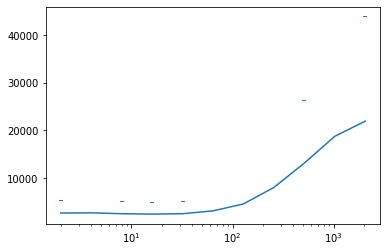

In [110]:
y_errors = np.transpose(response_set[:,2:])
plt.errorbar(response_set[:,0],response_set[:,1],yerr=y_errors,elinewidth=4)
plt.xscale('log')
plt.show()